# Homework 2.

Salette Guadalupe Noemi Villalobos A01246619

Erick Hernández Silva A01750170

Israel Sánchez Miranda A01378705

Loading imports and necessary libraries.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from argparse import ArgumentParser

# Region growing algorithm.

# Clustering algorithms for color images.

# Otsu algorithm.

The Otsu algorithm is a segmentation technique to separate the pixels of an image in two classes: the bakground and the object or first plane. Ths algortm finds the best threshold that minimizes the intra-class variance and maximizes the inter-class variance. This threshold will diide the pixels in two groups in such a way that the difference between the background and the object or first plane is the most.

Otsu has the following steps:
1. Calculate the pixel intensity histogram of the input image.
2. Calculate the cumulative probability for each intensity.
3. Obtain the cumulative median for the intensities.
4. For each intensity calculate the intra and inter-class variance.
5. Choose an optimal threshold value that minimizes intra-class variance (make pixels of this class as similar as possible) and maximizes inter-class variance (make pixels of other classes as different as possible).

To implement it in Python we first read an image in grayscale and use the `cv2.threshold` function over the image to apply the Otsu algorithm. We define the boundaries used in the histogram (`0` and `255` for intensities in grayscale images). And use a binary and Otsu thresholds to segmentate the image.

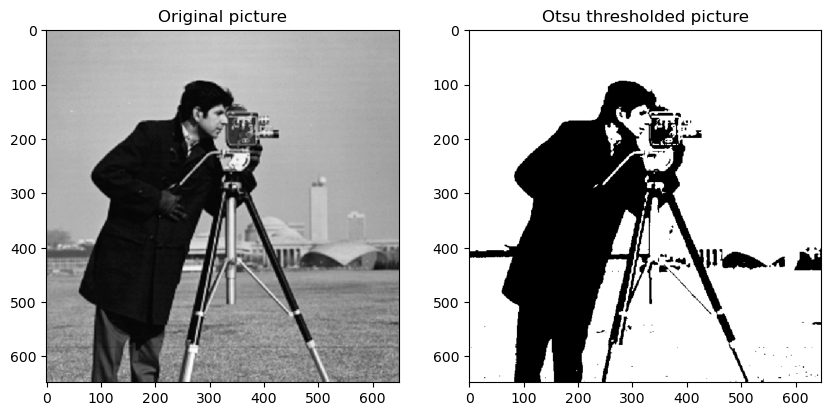

In [2]:
# Read image in grayscale
img = cv2.imread('cameraman.png', 0)

# Apply Otsu
_, otsu_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show original and threshold image
plt.figure(figsize=(10, 5))

# Original picture
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original picture')

# Otsu picture
plt.subplot(1, 2, 2)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu thresholded picture')

plt.show()

As we can see in the result, the original picture has different intensities in the grayscale domain. After using the Otsu algorithm this different intesities are discarded and we remain with a binary image with two classes: black and white pixels.

However, using Otsu algorithm isn't enough for correct segmentation. Particularly, this algorithm has two main weaknesses: If an image presents too much noise, Otsu will have trouble assignin a class to each pixel due to the high variation of intensity values. The other disadvantage of this algorithm is that if applied to an image where the background and the first plane or object have pixels with similar intensities (i.e. a blue object in a blue background) Otsu will have it hard to find an optimal treshold for segmentation.

To solve the first problem it is possible to apply morphological operators to reduce noise or fill gaps within objects. We first define a function `clean_segmentation` that will apply an opening or closing to the Otsu thresholded image to either reduce the noise (if opening operation is chosen) or to fill gaps within objects of the same class (if closing operation is chosen). we use the `cv2.morphologyEx` function to apply either the opening or closing function to the image, then we return the clean image.

In [3]:
def clean_segmentation(img, operation, kernel_size=(5, 5)):
    # Create a kernel for morphological operation
    kernel = np.ones(kernel_size, np.uint8)
    
    # Check which operation to apply
    if operation == 'opening':
        # Apply opening (erosion then dilation)
        clean_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':
        # Apply closing (dilation then erosion)
        clean_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError("Operation must be 'opening' or 'closing'.")
    
    return clean_img

We apply the function to the thresholded image and appreciate the results. The opening allows to extend the border of the object up to the noisy sections in order to reduce it while the closing completely reduces the noise around the object due to the dilation followed by the erosion.

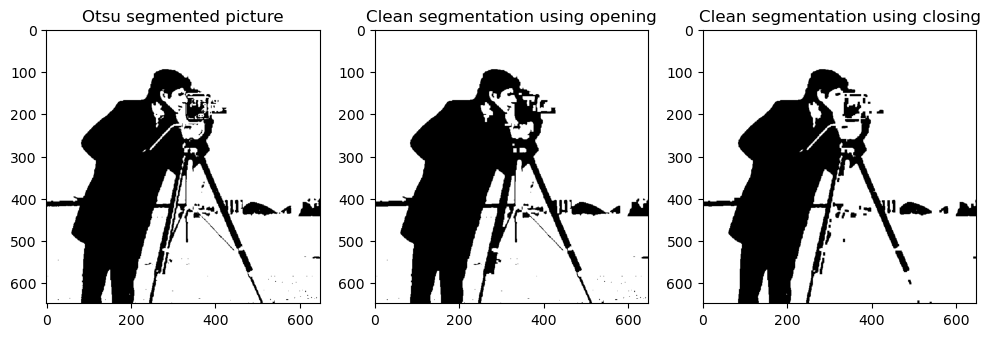

In [4]:
# Clean Otsu image with 'opening'
otsu_opening_img = clean_segmentation(otsu_img, 'opening')

# Clean Otsu image with 'closing'
otsu_closing_img = clean_segmentation(otsu_img, 'closing')

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu segmented picture')

plt.subplot(1, 3, 2)
plt.imshow(otsu_opening_img, cmap='gray')
plt.title('Clean segmentation using opening')

plt.subplot(1, 3, 3)
plt.imshow(otsu_closing_img, cmap='gray')
plt.title('Clean segmentation using closing')

plt.show()

## Distance map for Otsu

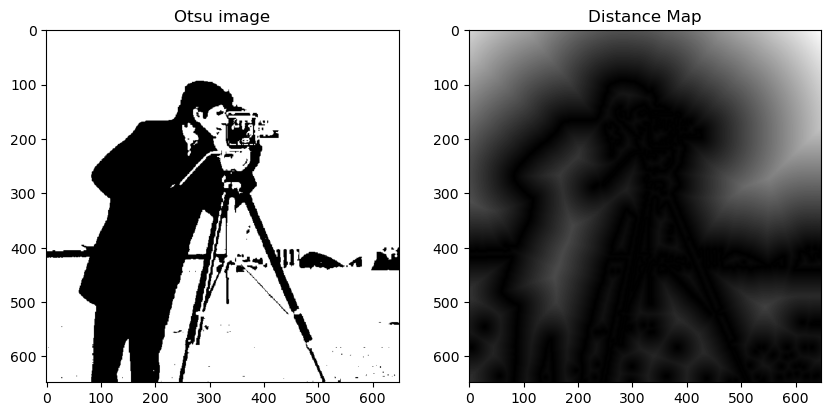

In [5]:
# Find the object boundaries (edges)
edges = cv2.Canny(otsu_img, 100, 200)

# Compute the distance map from the object boundaries
# Use the distance transform, where we treat the edge pixels as the '0' or boundary
distance_map = distance_transform_edt(~edges)

# Display the results
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu image')

plt.subplot(1, 2, 2)
plt.imshow(distance_map, cmap='gray')
plt.title('Distance Map')
plt.show()

# Skeleton algorithm

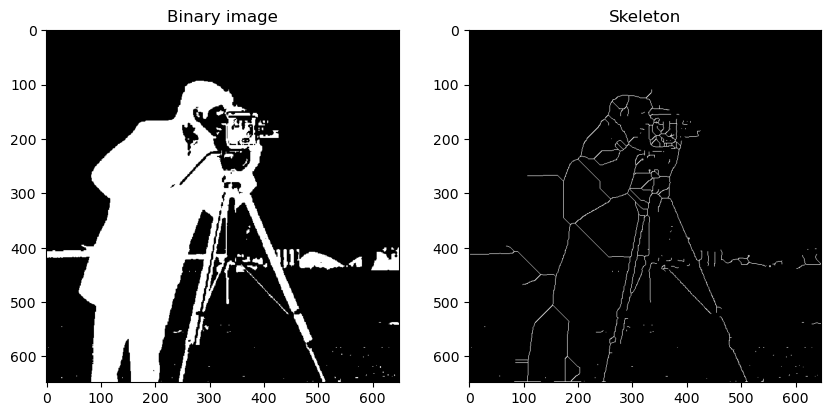

In [6]:
# Invert the binary image (object is white, background is black)
inverted = 255 - otsu_img

# Perform skeletonization using OpenCV's thinning function
skeleton = cv2.ximgproc.thinning(inverted)

# Display the results
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(inverted, cmap='gray')
plt.title('Binary image')

plt.subplot(1, 2, 2)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeleton')
plt.show()


# Optical flow

In [12]:
def lucas_kanade_method(video_path):
    cap = cv2.VideoCapture(video_path)
    # params for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, p0, None, **lk_params
        )
        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
        img = cv2.add(frame, mask)
        cv2.imshow("frame", img)
        k = cv2.waitKey(25) & 0xFF
        if k == 27:
            break
        if k == ord("c"):
            mask = np.zeros_like(old_frame)
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

In [8]:
def dense_optical_flow(method, video_path, params=[], to_gray=False):
    # read the video
    cap = cv2.VideoCapture(video_path)
    # Read the first frame
    ret, old_frame = cap.read()

    # crate HSV & make Value a constant
    hsv = np.zeros_like(old_frame)
    hsv[..., 1] = 255

    # Preprocessing for exact method
    if to_gray:
        old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    while True:
        # Read the next frame
        ret, new_frame = cap.read()
        frame_copy = new_frame
        if not ret:
            break
        # Preprocessing for exact method
        if to_gray:
            new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
        # Calculate Optical Flow
        flow = method(old_frame, new_frame, None, *params)

        # Encoding: convert the algorithm's output into Polar coordinates
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Use Hue and Saturation to encode the Optical Flow
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        # Convert HSV image into BGR for demo
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        cv2.imshow("frame", frame_copy)
        cv2.imshow("optical flow", bgr)
        k = cv2.waitKey(25) & 0xFF
        if k == 27:
            break
        old_frame = new_frame

# Segmentation pipeline.

In [ ]:
# Loading the image 
img = cv2.imread('Images/img5.png')